# Electricity uptime

I want to observe the time that the grid is operating and compare that to the intended operating time as well as the desired operating time from the perspective of the residents.

Possible approaches:

- Sort index and take differences of the time stamps histogram
- Look at how to calculate number of days with valid data
- Calculate uptime
- Compare communication and power up/down time stamps with reported data

Problems

- Pandas used to have a discrete difference but now I think I have to use numpy

In [1]:
import pandas as pd

def parse_file(energy_file_name):
    # read in raw CSV file for preprocessing
    energy_file = open(energy_file_name)
    # append data lines after header beginning with 'Timestamp'
    # dump lines from communications messages or empty lines and write to string
    file_string = ''
    omit_strings = ['Power Up', 'Communication Lost', 'Power Down', ',,,,,,,,,,,']
    # append data not matching omit_strings after sentinel is reached
    data_found = False
    for line in energy_file.readlines():
        if 'Timestamp' in line:
            data_found = True
        if not any(omit in line for omit in omit_strings) and data_found:
            file_string += line
    return file_string    

def create_data_frame(energy_file_name):
    # use pre-parsed string to read in data file to pandas and sort by date
    file_string = parse_file(energy_file_name)
    import io
    energy_data = pd.read_csv(io.StringIO(file_string),
                          index_col=0, 
                          parse_dates=[0], 
                          thousands=',')
    energy_data = energy_data.sort_index()
    return energy_data

def get_energy_stats(energy_data):
    energy = energy_data['kWh export']
    resampled = energy.resample('D').diff()
    return resampled.mean(), resampled.median()

# Initial Visualization

By plotting the date against the integer index of the dates, we can see discontinuities in service as vertical steps.  One approach is to add together differences in time stamps below a certain value as service and above a certain value as an outage.

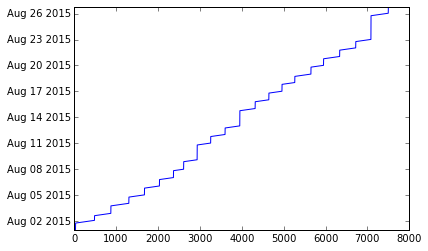

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

energy_file_name = "../data-timeseries/Data_Logs Atamali Agustus.csv"
energy_data = create_data_frame(energy_file_name)
plt.plot(energy_data.index)

# Differences

We can take a discrete difference and count the distance between time stamps.  We see that there are thousands of observations at one minute and many observations at longer time differences.  By multiplying the time difference by the number of observations, we can get the down and up time.

In [3]:
import numpy as np
from pint import UnitRegistry
u = UnitRegistry()

# take the discrete difference between time samples
# convert to seconds from nanoseconds
# put in pandas series
differences = np.diff(energy_data.index.values)/1e9
differences = differences.astype(int)
diff_series = pd.Series(differences)

# use value counts to see intervals
dsvc = diff_series.value_counts()
dsvc.sort_index()

59        3605
60        3901
119          2
46620        1
61259        1
62039        1
62699        1
62999        1
64020        1
64440        1
64860        1
65100        1
65459        1
65699        1
66720        1
67319        1
67740        1
68519        1
68879        1
69360        1
74520        1
75180        1
147480       1
151440       1
236639       1
dtype: int64

We can multiply the index values which are durations in seconds, by the values in the series which are numbers of observations to get the total seconds for each observation.  By splitting these into observations of about a minute difference and observations over a minute and summing them, we can estimate the grid downtime and uptime.

In [4]:
cutoff_seconds = 60
uptime = dsvc[dsvc.index <= cutoff_seconds]
downtime = dsvc[dsvc.index > cutoff_seconds]

inferred_uptime = (uptime.index * uptime).values.sum() * u.second
inferred_downtime = (downtime.index * downtime).values.sum() * u.second

print('uptime', inferred_uptime)
print('downtime', inferred_downtime)

uptime 446755 second
downtime 1779228 second


By subtracting the last entry timestamp and the first, we calculate the total time period covered by the data and store it in a ```clock_time``` variable.

In [5]:
clock_time = (energy_data.index[-1] - energy_data.index[0]).total_seconds() * u.seconds
print('data range', clock_time.to(u.day))

data range 25.805555335648144 day


I can infer the total time from the total of the differences between samples.  We note that this is slightly different, possibly due to the truncation of seconds.  

In [6]:
inferred_time = (dsvc.index * dsvc).values.sum() * u.second
inferred_time.to(u.day)

<Quantity(25.763692129629625, 'day')>

In [7]:
# fractional difference between samples and clock time
(inferred_time - clock_time)/clock_time

<Quantity(-0.0016222555753601547, 'dimensionless')>

Dividing these two allows you to see the percentage of the time the grid is running.

In [8]:
inferred_uptime / clock_time

<Quantity(0.200374508345495, 'dimensionless')>